In [ ]:
!pip install -q kaggle

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']="/content"

In [ ]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
 99% 2.67G/2.70G [00:10<00:00, 322MB/s]
100% 2.70G/2.70G [00:10<00:00, 273MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/new-plant-diseases-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import skimage
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [ ]:


# The path of the dataset
train_data_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_data_path = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

categories = os.listdir(train_data_path)
print(f'The Number Of categories are : {len(categories)} Category')

The Number Of categories are : 38 Category


In [ ]:
cat_freq = {}
for cat in categories:
    cat_freq[cat] = len(os.listdir(train_data_path + "/" + cat))

cat_freq_df = pd.DataFrame.from_dict(cat_freq, orient='index', columns=['Frequencies'])

cat_freq_df.reset_index(inplace=True)
cat_freq_df.columns = ['Categories', 'Frequencies']
cat_freq_df

,Categories,Frequencies
0,Apple___Black_rot,1987
1,Corn_(maize)___Common_rust_,1907
2,Tomato___Tomato_mosaic_virus,1790
3,Tomato___Spider_mites Two-spotted_spider_mite,1741
4,Tomato___Leaf_Mold,1882
5,Tomato___Septoria_leaf_spot,1745
6,Grape___Black_rot,1888
7,Peach___Bacterial_spot,1838
8,Orange___Haunglongbing_(Citrus_greening),2010
9,Tomato___Early_blight,1920


In [ ]:
cat_freq_df.describe()

,Frequencies
count,38.000000
mean,1849.868421
std,105.724315
min,1642.000000
25%,1763.500000
50%,1844.500000
75%,1924.500000
max,2022.000000


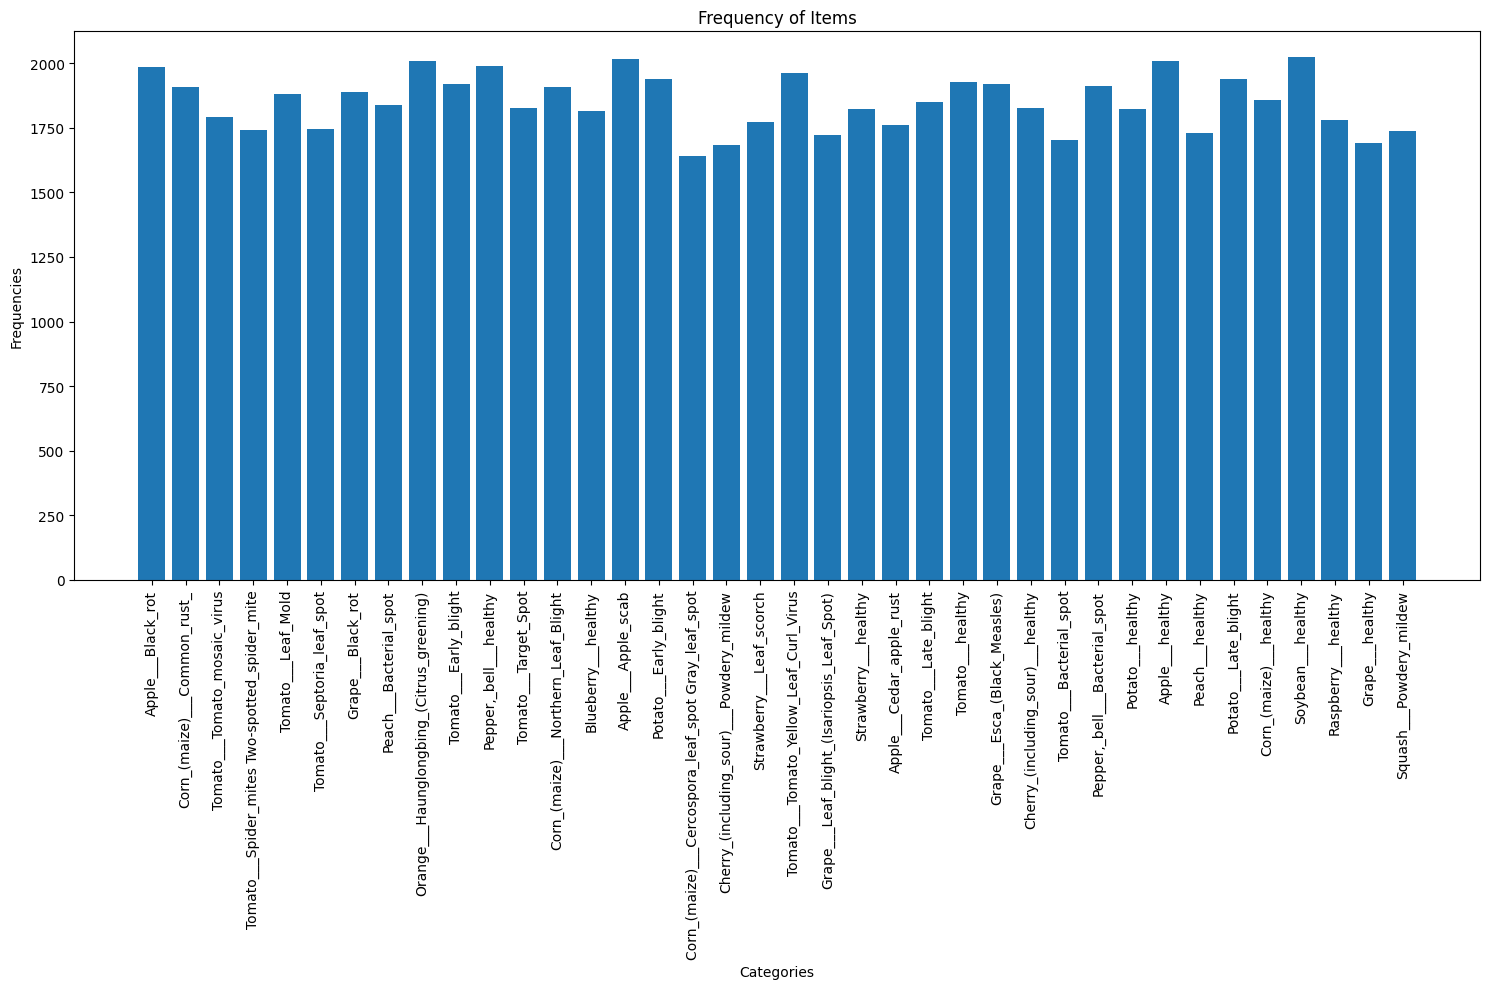

In [ ]:
plt.figure(figsize=(15, 10))
plt.bar(cat_freq_df['Categories'], cat_freq_df['Frequencies'])
plt.xlabel('Categories')
plt.ylabel('Frequencies')
plt.title('Frequency of Items')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
fruits_veg = []
for cat in categories:
    fruits_veg.append(cat.split('___')[0])
unique_fruites_veg = list(np.unique(fruits_veg))

print(f'The represents {len(unique_fruites_veg)} Different types of Fruits and Vegetables as follows : ')
unique_fruites_veg

The represents 14 Different types of Fruits and Vegetables as follows : 


['Apple',
 'Blueberry',
 'Cherry_(including_sour)',
 'Corn_(maize)',
 'Grape',
 'Orange',
 'Peach',
 'Pepper,_bell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato']

In [ ]:
veg_fruite_cat = {}
for i in unique_fruites_veg:
    num = 0
    for j in categories:
        if i in j:
            num +=1
    veg_fruite_cat[i] = num
veg_fruite_cat

{'Apple': 4,
 'Blueberry': 1,
 'Cherry_(including_sour)': 2,
 'Corn_(maize)': 4,
 'Grape': 4,
 'Orange': 1,
 'Peach': 2,
 'Pepper,_bell': 2,
 'Potato': 3,
 'Raspberry': 1,
 'Soybean': 1,
 'Squash': 1,
 'Strawberry': 2,
 'Tomato': 10}

In [ ]:
# Define paths for the sampled dataset
sampled_train_dir = 'Dataset\\Sampled\\train\\'
sampled_valid_dir = 'Dataset\\Sampled\\valid\\'

In [ ]:

# Create directories if they don't exist
os.makedirs(sampled_train_dir, exist_ok=True)
os.makedirs(sampled_valid_dir, exist_ok=True)

In [ ]:
def sample_dataset(data_dir, output_dir, sample_size=0.1):
    """
    Sample a subset of the dataset.

    Parameters:
    - data_dir: The directory containing the original dataset.
    - output_dir: The directory where the sampled dataset will be stored.
    - sample_size: The fraction of the dataset to sample.
    """
    categories = os.listdir(data_dir)

    for category in categories:
        # Create category directory in the sampled output directory
        os.makedirs(os.path.join(output_dir, category), exist_ok=True)

        # Get all images in the current category
        images = os.listdir(os.path.join(data_dir, category))

        # Sample a fraction of the images
        sampled_images = np.random.choice(images, int(len(images) * sample_size), replace=False)

        # Copy the sampled images to the output directory
        for image in sampled_images:
            src = os.path.join(data_dir, category, image)
            dst = os.path.join(output_dir, category, image)
            shutil.copy(src, dst)

In [ ]:
# Sample 10-20% of the dataset
sample_percentage = 1.0 # Adjust between 0.1 and 0.2 for 10-20%
sample_dataset(train_data_path, sampled_train_dir, sample_percentage)
sample_dataset(valid_data_path, sampled_valid_dir, sample_percentage)

In [ ]:
# Set up ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(256, 256),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create validation data generator
validation_generator = validation_datagen.flow_from_directory(
    valid_data_path,
    target_size=(256, 256),  # Resize images to match model input
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Load the DenseNet121 model with pre-trained weights from ImageNet, excluding the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add new layers on top of the base model for our specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions

x = Dense(1024, activation='relu')(x)  # Dense layer with 1024 units and ReLU activation

# Output layer - adjust the number of classes according to the dataset (e.g., train_generator.num_classes)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_282 (Conv2D)         (None, 127, 127, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_282 (B  (None, 127, 127, 32)         96        ['conv2d_282[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_282 (Activation  (None, 127, 127, 32)         0         ['batch_normalization_28

In [ ]:
# Define callbacks
checkpoint_path = "best_InceptionV3_model.h5"  # Path where the best model will be saved

checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=3, mode='max', verbose=1, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,  # Your training data generator
    epochs=10,  # Adjust the number of epochs as needed
    validation_data=validation_generator,  # Your validation data generator
    callbacks=[checkpoint, early_stopping, reduce_lr]  # Add the callbacks here
)

Epoch 1/10
2197/2197 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.8396 - precision: 0.8986 - recall: 0.7953
Epoch 1: val_accuracy improved from -inf to 0.87799, saving model to best_model.h5
2197/2197 [==============================] - 711s 321ms/step - loss: 0.5082 - accuracy: 0.8396 - precision: 0.8986 - recall: 0.7953 - val_loss: 0.3603 - val_accuracy: 0.8780 - val_precision: 0.9107 - val_recall: 0.8534 - lr: 0.0010
Epoch 2/10
2197/2197 [==============================] - ETA: 0s - loss: 0.2724 - accuracy: 0.9084 - precision: 0.9272 - recall: 0.8937
Epoch 2: val_accuracy improved from 0.87799 to 0.89739, saving model to best_model.h5
2197/2197 [==============================] - 700s 318ms/step - loss: 0.2724 - accuracy: 0.9084 - precision: 0.9272 - recall: 0.8937 - val_loss: 0.3067 - val_accuracy: 0.8974 - val_precision: 0.9139 - val_recall: 0.8848 - lr: 0.0010
Epoch 3/10
2197/2197 [==============================] - ETA: 0s - loss: 0.2120 - accuracy: 0.9272

In [ ]:
 #Load the best model saved during training
best_model = tf.keras.models.load_model('best_model.h5')

In [ ]:
 #Evaluate the model on validation data
loss, accuracy, precision, recall = best_model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')

550/550 [==============================] - 136s 244ms/step - loss: 0.1656 - accuracy: 0.9533 - precision: 0.9565 - recall: 0.9505
Validation Loss: 0.16563324630260468
Validation Accuracy: 0.9533348679542542
Validation Precision: 0.956534206867218
Validation Recall: 0.9505463242530823


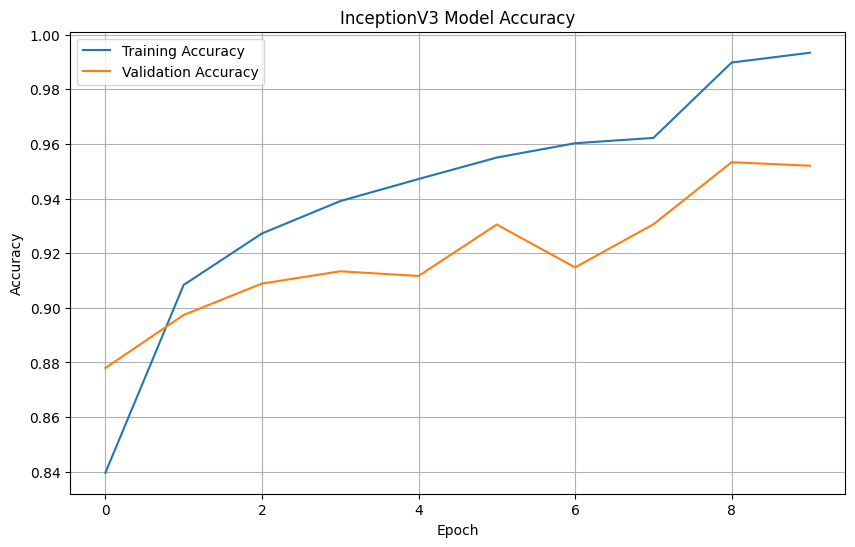

In [ ]:
#Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

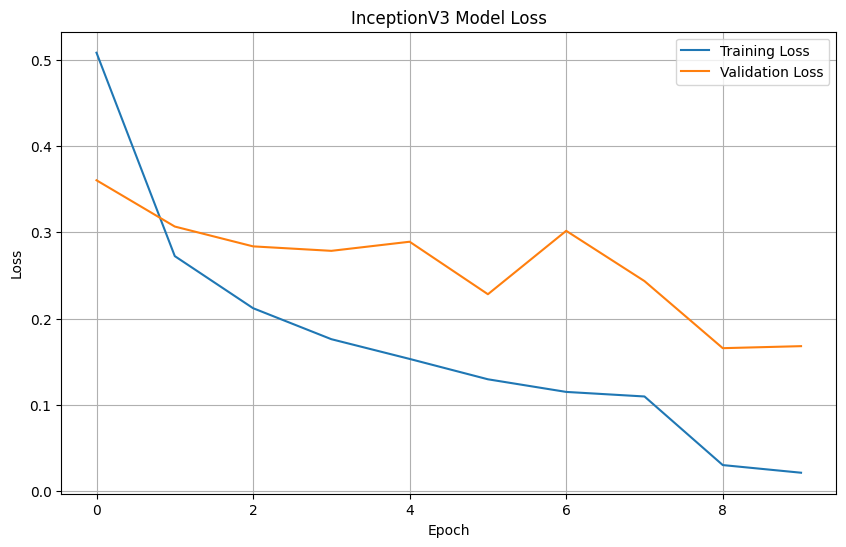

In [ ]:
#Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

550/550 [==============================] - 130s 234ms/step


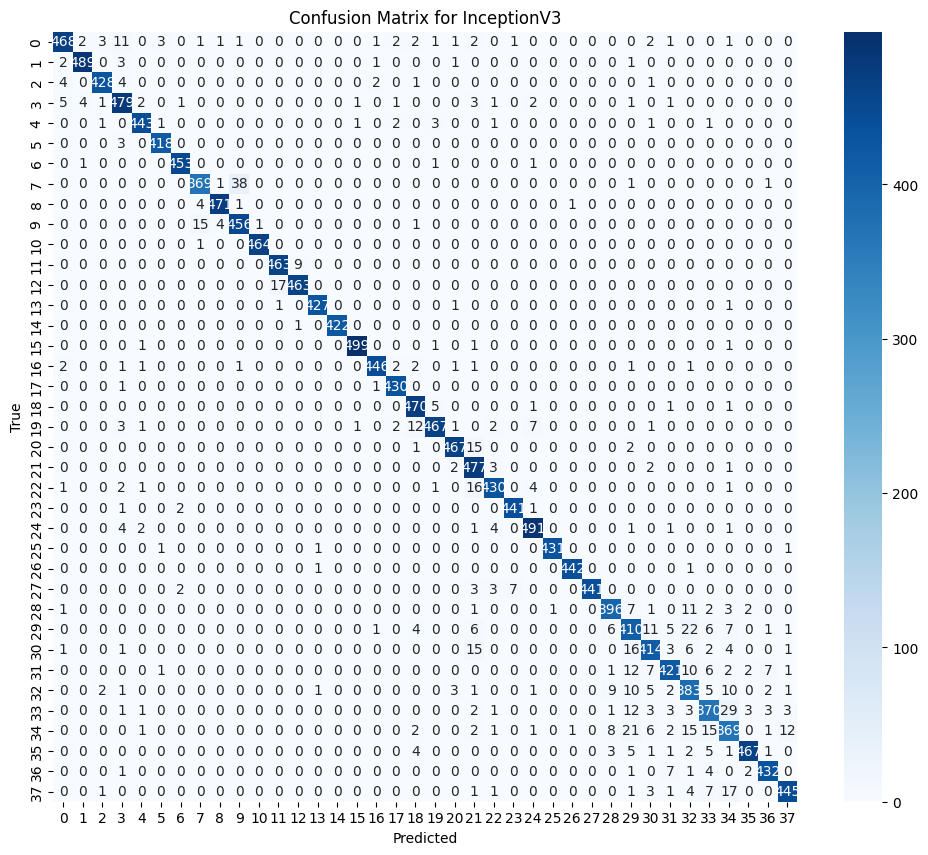

In [ ]:
from sklearn.metrics import confusion_matrix

Y_pred = best_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for InceptionV3')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import f1_score, roc_curve, auc, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
validation_generator.reset()

y_pred = best_model.predict(validation_generator, verbose=1)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes
class_indices = validation_generator.class_indices

inverse_class_indices = {v: k for k, v in class_indices.items()}

550/550 [==============================] - 131s 238ms/step


In [ ]:
f1 = f1_score(y_true, y_pred_class, average='macro')
print(f"Macro F1 Score: {f1}")

Macro F1 Score: 0.953440483817849


In [ ]:
# R2 Score
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(validation_generator.class_indices))
r2 = r2_score(y_true_one_hot, Y_pred)
print(f"R2 Score: {r2}")

R2 Score: 0.9251518249511719


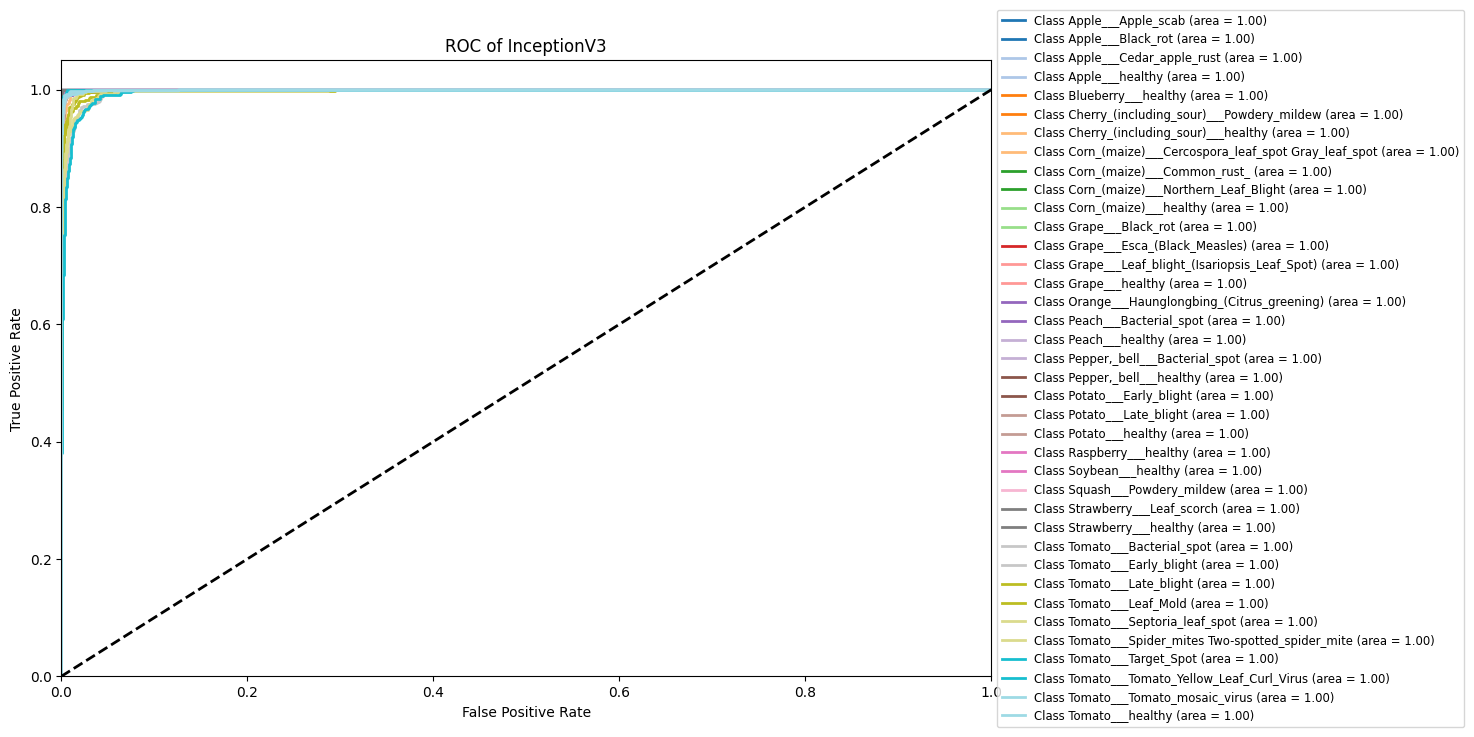

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import matplotlib.cm as cm

# Binarize the output labels for ROC curve calculation
y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
n_classes = y_true_bin.shape[1]

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Generate a colormap with 8 different colors
colors = cm.get_cmap('tab20', n_classes)
3
# Plotting all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='Class {0} (area = {1:0.2f})'.format(inverse_class_indices[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of InceptionV3')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Adjusted font size and position
plt.show()

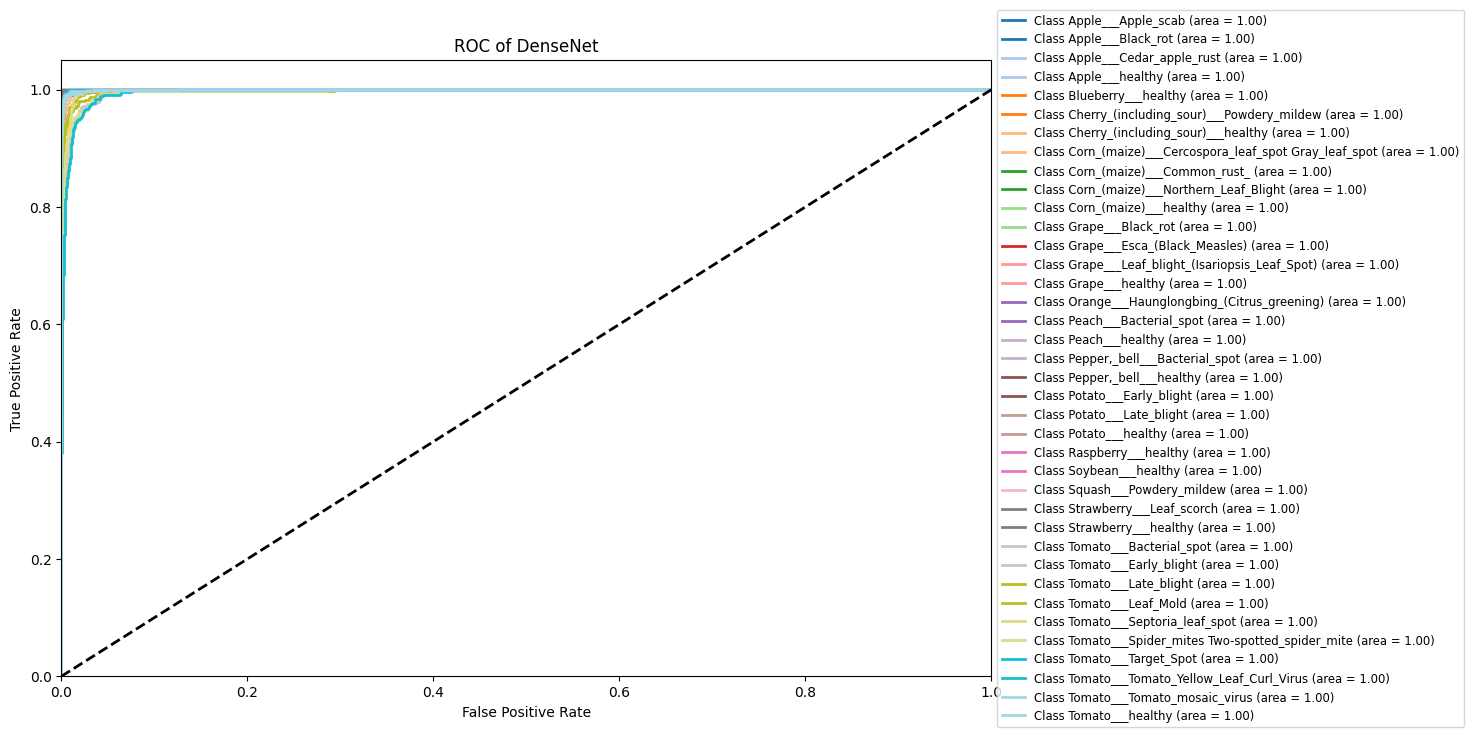

In [ ]:
# ROC Curve
# Binarize the output labels for ROC curve calculation
class_indices = validation_generator.class_indices
inverse_class_indices = {v: k for k, v in class_indices.items()}
y_true_bin = label_binarize(y_true, classes=list(range(len(class_indices))))
n_classes = y_true_bin.shape[1]

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Generate a colormap with n different colors
colors = cm.get_cmap('tab20', n_classes)

# Plotting all ROC curves
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label='Class {0} (area = {1:0.2f})'.format(inverse_class_indices[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of DenseNet')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Adjusted font size and position
plt.show()

In [ ]:
# Create a proper inverse mapping of class indices to labels

inverse_class_indices = {v: k for k, v in class_indices.items()}  # Make sure class_indices maps string to index

def predict_image(model, image_path, class_indices):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0

    # Expand dimensions to match input shape
    img = np.expand_dims(img, axis=0)

    # Make prediction
    predictions = model.predict(img)

    # Find the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    print(f'Predicted Class Index: {predicted_class_index}')
    print(f'Available Indices in inverse_class_indices: {list(inverse_class_indices.keys())}')

    # Ensure that the predicted class index exists in class_indices
    if predicted_class_index in inverse_class_indices:
        predicted_class_label = inverse_class_indices[predicted_class_index]
        confidence_score = predictions[0][predicted_class_index]
        return predicted_class_label, confidence_score
    else:
        raise ValueError(f'Predicted index {predicted_class_index} not found in inverse_class_indices.')

# Use the prediction function again
image_path = '/content/test/test/AppleScab1.JPG' # Replace with your image path
predicted_label, confidence = predict_image(best_model, image_path, inverse_class_indices)

# Print the result
print(f'Predicted Label: {predicted_label}')
print(f'Confidence Score: {confidence:.4f}')

1/1 [==============================] - 1s 1s/step
Predicted Class Index: 0
Available Indices in inverse_class_indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
Predicted Label: Apple___Apple_scab
Confidence Score: 0.9993
